# Hypercube model

## Basic model

Let's start by playing with a hypercube model.
In this model we imagine that every person has a number of neighbours that they could potentially get/give covid-19 from/to.

If we imagined a matrix, then each person would have 8 neighbours.
In a cube tensor, each person would have $8 + 9 + 9 = 26$ neighbours.
In an n-dimensional tensor, each person has $3^n - 1$ neighbours.

Let's begin with an easy tensor. 0 represents someone who is uninfected, 1 represents someone who is infected, and NA represents either someone who doesn't exist or someone who is no longer at risk (dead or immune).

In [ ]:
using StatsBase
using Plots

In [18]:
N = 4
total_people = 10000

tensor = zeros(Union{Missing, Int64}, (Int(ceil(total_people^(1/N))) for i in 1:N)...)
total_neighbours = 3^N - 1

locs = sample(1:((Int(ceil(total_people^(1/N))))^N),((Int(ceil(total_people^(1/N))))^N - total_people), replace=false)
tensor[locs] .= missing;

We begin by making a few `n0` people unwell.

In [19]:
n0 = 10
locs = sample(1:length(tensor), n0, replace=false)
tensor[locs] .= 1;
sum(skipmissing(tensor)) ##should be 10

10

First we iterate over each of the people who are unwell.
The probability of them dying in that step is `mortrate`.
The probability of them becoming well in that step is `healrate`.

Then each step we iterate over the neighbours of people with illness.
The average number of people who become infected by someone who is infected is `r0`.
This must be done in the average time of being infected, i.e. 1/(`mortrate` + `healrate`).
Therefore the average number of infections per step is `r0` * (`mortrate` + `healrate`).

The probability of each of the neighbours becoming 1 is `r0` * (`mortrate` + `healrate`) * 1 / `total_neighbours`.
If someone has two neighbours they will be iterated over twice.

Then we can sum the array to know the number infected.

In [20]:
"""
infect_neighbours(array, prob_infection)

Iterates through the neighbours of infected people in the array and
infects people randomly.
"""
function infect_neighbours(array::Array{Union{Int64, Missing}}, prob_infection)
    num_infected = 0
    for infected in findall(coalesce.(array .== 1, false))
        neighbours = get_neighbours(array, infected)
        for i in eachindex(neighbours)
            neighbours[i], change = infect(neighbours[i], prob_infection)
            num_infected += change
        end

    end
    return array, num_infected
end

infect_neighbours

In [21]:
mortrate = 0.01
healrate = 0.1
r0 = 2
prob_infection = r0 * (mortrate + healrate) / (3^N - 1)

0.00275

In [22]:
function infect(value::Union{Int64, Missing}, prob_infection::Float64)
    if (coalesce(value,-1) == 0) && (rand() < prob_infection)
        return 1, 1
    end
    
    return value, 0
end

infect (generic function with 1 method)

In [23]:
function find_indices(pos, len)
    start = pos - 1
    if pos == 1
        start = 1
    end
    last = pos + 1
    if pos == len
        last = len
    end
    return(start:last)
end

find_indices (generic function with 1 method)

In [24]:
function get_neighbours(array, cartind)
    len = size(array)[1]
    tpl = Tuple(cartind)

    return(view(array, (find_indices(i, len) for i in tpl)...))
    
end

get_neighbours (generic function with 1 method)

In [25]:
function heal_or_die(array, mortrate, healrate)
    nmort = 0
    nheal = 0
    
    for i in eachindex(array)
        if coalesce(array[i],0) == 1
            rnd = rand()
            if rnd < mortrate
                array[i] = missing
                nmort += 1
            end
            if rnd < (mortrate + healrate) && rnd > mortrate
                array[i] = missing
                nheal += 1
            end
        end
    end
    return(array,nmort,nheal)
end

heal_or_die (generic function with 1 method)

In [26]:
# get_neighbours(tensor, findall(coalesce.(tensor .== 1, false))[3])

In [27]:
infected = [sum(skipmissing(tensor))]
deaths = [0]
survivals = [0]
infections = [sum(skipmissing(tensor))]

for step in 1:1000
    tensor, ndead, nhealed = heal_or_die(tensor, mortrate, healrate)
    append!(deaths, ndead)
    append!(survivals, nhealed)
    tensor, num_infected = infect_neighbours(tensor, prob_infection)
    append!(infected, sum(skipmissing(tensor)))
    append!(infections, num_infected)
end

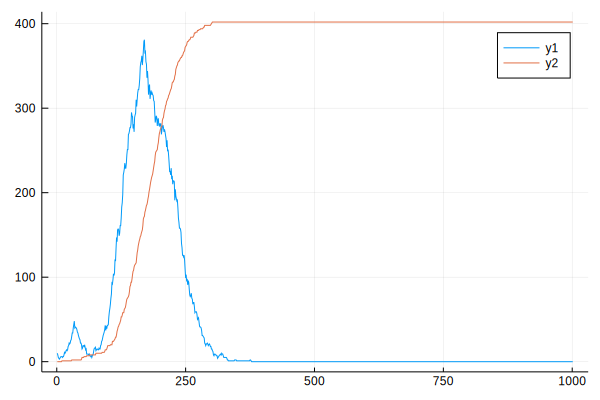

In [28]:
infected_no_travel = infected
plot([infected_no_travel, cumsum(deaths)])

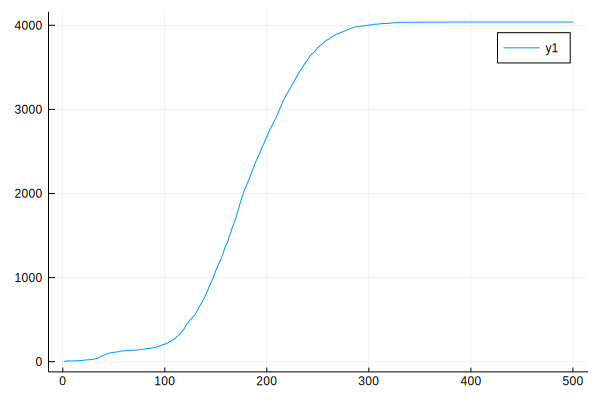

In [29]:
plot([cumsum(infections)[1:500],cumsum(survivals)[1:500])

## The effects of travel

When people move about do they contribute to the spread of the virus?
Let's investigate by randomly moving people about. 

In [35]:
function switch_places(array, n)
    locs = sample(1:length(array), n, replace=false)
    value_last = array[locs[length(locs)]]
    for i in 2:length(locs)
        array[locs[i]] = array[locs[i-1]]
    end
    array[locs[1]] = value_last
    return array
end

switch_places (generic function with 1 method)

In [36]:
N = 4
total_people = 10000

tensor = zeros(Union{Missing, Int64}, (Int(ceil(total_people^(1/N))) for i in 1:N)...)
total_neighbours = 3^N - 1

locs = sample(1:((Int(ceil(total_people^(1/N))))^N),((Int(ceil(total_people^(1/N))))^N - total_people), replace=false)
tensor[locs] .= missing;

n0 = 10
locs = sample(1:length(tensor), n0, replace=false)
tensor[locs] .= 1;

mortrate = 0.01
healrate = 0.1
r0 = 2
prob_infection = r0 * (mortrate + healrate) / (3^N - 1)

infected = [sum(skipmissing(tensor))]
deaths = [0]
survivals = [0]
infections = [sum(skipmissing(tensor))]

for step in 1:1000
    tensor, ndead, nhealed = heal_or_die(tensor, mortrate, healrate)
    tensor = switch_places(tensor, 100)
    tensor, num_infected = infect_neighbours(tensor, prob_infection)
    append!(deaths, ndead)
    append!(survivals, nhealed)
    append!(infected, sum(skipmissing(tensor)))
    append!(infections, num_infected)
end

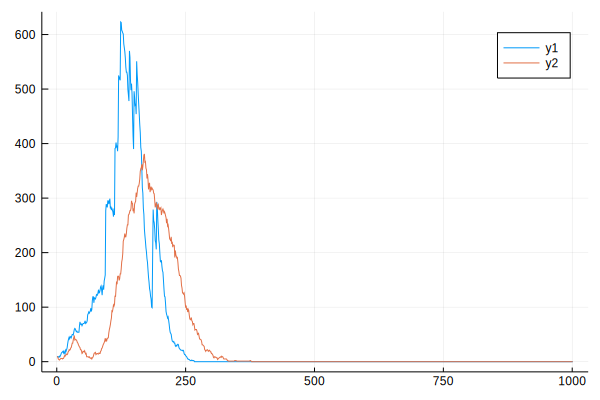

In [37]:
plot([infected, infected_no_travel])

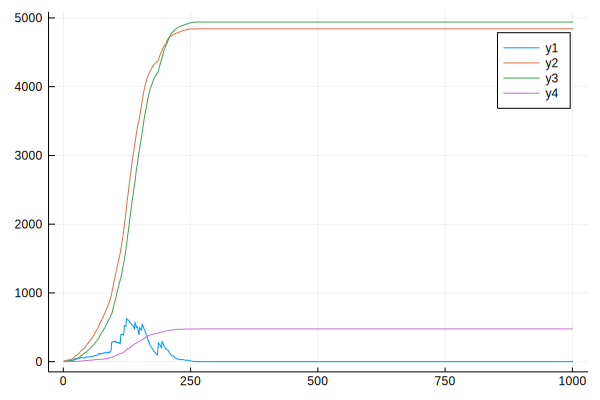

In [38]:
plot([infected, cumsum(infections), cumsum(survivals), cumsum(deaths)])

You can see quite clearly from the above charts that travel gives a multipeak profile to the number of people infected, increases the height of the peak, decreases the lead-in time, and appears to increase the number of infections.

## Developing statistical distributions

So far we have just been running tests. 
We now want to understand what the range of potential values are, and what the main drivers are.
Let's start with smaller versions of the model to reduce computation time.
We can make a couple of convenience functions to help.

In [47]:
function run_model(
        nsteps, 
        N=4, 
        total_people=10000, 
        n0=10, 
        mortrate=0.01, 
        healrate=0.1,
        r0=2,
    )
    prob_infection = r0 * (mortrate + healrate) / (3^N - 1)
    
    
    tensor = zeros(Union{Missing, Int64}, (Int(ceil(total_people^(1/N))) for i in 1:N)...)
    total_neighbours = 3^N - 1

    locs = sample(1:((Int(ceil(total_people^(1/N))))^N),((Int(ceil(total_people^(1/N))))^N - total_people), replace=false)
    tensor[locs] .= missing;

    locs = sample(1:length(tensor), n0, replace=false)
    tensor[locs] .= 1;
    
    infected = [sum(skipmissing(tensor))]
    deaths = [0]
    survivals = [0]
    infections = [sum(skipmissing(tensor))]

    for step in 1:nsteps
        tensor, ndead, nhealed = heal_or_die(tensor, mortrate, healrate)
        append!(deaths, ndead)
        append!(survivals, nhealed)
#         tensor = switch_places(tensor, 100)
        tensor, num_infected = infect_neighbours(tensor, prob_infection)
        append!(infected, sum(skipmissing(tensor)))
        append!(infections, num_infected)
    end
    return(infected,infections,survivals,deaths)
end

run_model (generic function with 7 methods)

### Baseline modelling

We are going to produce our baseline model now.

In [132]:
infectedlist = []
infectionslist = []
survivalslist = []
deathslist = []

for i in 1:100
    infected,infections,survivals,deaths = run_model(350)
    append!(infectedlist, infected)
    append!(infectionslist, infections)
    append!(survivalslist, survivals)
    append!(deathslist, deaths)
end



In [145]:
infectedlist, infectionslist, survivalslist, deathslist = (convert(Array{Int64}, reshape(i, 351, 100)) for i in [infectedlist, infectionslist, survivalslist, deathslist])

Base.Generator{Array{Array{Any,1},1},var"#19#20"}(var"#19#20"(), Array{Any,1}[[10, 9, 9, 9, 9, 9, 9, 11, 11, 14  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [10, 1, 1, 2, 1, 2, 2, 2, 0, 4  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 1, 2, 0, 1, 2, 0, 0, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

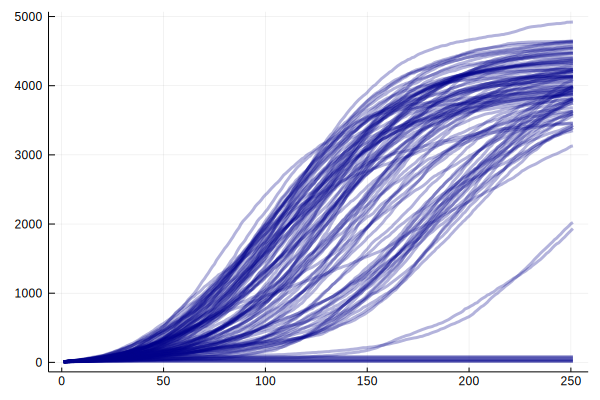

In [128]:
plot(1:251,convert(Array{Int64},cumsum(reshape(infectionslist,251,100), dims = 1)), color="darkblue",w=3,alpha=0.3, legend = nothing)

In [105]:
reshape(infectedlist,251,100)

251×100 Array{Any,2}:
 10  10  10  10  10  10  10  10  10  10  …  10   10  10  10   10  10  10  10
 10  11  10  10  12   9  10  10  11  12     10   11   8  11   10  11  12  10
 10  12  10  12  13  12  12   9  12  12     10   10   8  13    8  10  13   9
 11  13  11  14  16  13  14   9  13  11     12   10   7  14    7  15  13  10
 12  16  11  12  16  12  14   6  12   9     12    8  10  16    4  17  15  11
 11  15  10  11  19  13  16   8  12  11  …  12    9   8  15    4  17  17  14
 10  16  14  12  16  15  17   6  11  11     11   12   7  16    4  16  16  13
 10  20  12  14  19  15  17   6  13  15     12   10   9  21    4  16  16  14
 12  20  16  15  23  16  20   7  14  15     13   10  11  18    4  17  13  15
 13  27  15  15  24  19  19   7  17  15      9   10  11  20    4  22  12  15
 15  27  17  15  21  24  20   8  13  18  …  14   13  11  16    4  24  12  16
 17  25  20  17  22  24  21  10  13  17     16   13   9  19    4  25  13  16
 17  22  23  20  24  26  25   9  13  16     20   11  1

### The effects of N

`N` is the number of dimensions in our hypercube. 
$3^N$ is a proxy for the estimated number of people that we might come in contact with (our "neighbours"). 
There are a couple of issues with our model.
Firstly, literal "edge cases".
The hypercube's edges curb the reproductive behaviour - there might be some fixes we can apply to this.

In [ ]:
infectedlist = []
infectionslist = []
survivalslist = []
deathslist = []

for N in [1,2,3,4,5,6,7,8,9,10]
    run_model(10,N=N)
    
    

### The effects of r0

`r0` is our base rate of reproduction.
It represents the expected number of infections one infection produces if the original infection is surrounded by uninfected neighbours.
We know that if r0 is less than 1 then we 